In [1]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.notebook import trange, tqdm, tqdm_notebook
from joblib import Parallel, delayed
import re
import h5py
import tifffile as tiff


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = (Path().cwd().parents[0] / 'data').absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
df_imgs_path = data_dir / 'Navincin'  /'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_imgs_path)

# Generate scatter plot

In [5]:
import napari 

# remove first and last consecutive zeros along dimension
def removeFirstAndLast(zeroArray):
    
    # remove first
    for ii, val in enumerate(zeroArray):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            lowest = ii # index of last of the first consecutive zeros
            
    # remove last
    for ii, val in enumerate(np.flip(zeroArray)):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            highest = len(zeroArray) - ii # index of first of the last consecutive zeros            
    
    return (lowest, highest)

# remove black borders from napari screenshot (2D image)
def removeBorders(RGB):
    rowMin = []
    rowMax = []
    colMin = []
    colMax = []
    for jj in range(3): # each RGB
        
        img = RGB[:, :, jj]
        # find first and last rows and cols of all zeros
        # remove any rows of zeros
        zeroRows = np.all(img == 0, axis = 1)
        zeroCols = np.all(img == 0, axis = 0)

        posRows = removeFirstAndLast(zeroRows)
        posCols = removeFirstAndLast(zeroCols)            
        
        rowMin.append(posRows[0])
        rowMax.append(posRows[1])
        colMin.append(posCols[0])
        colMax.append(posCols[1])
        
    # make sure border signal is not cut out
    rowMin = np.min(rowMin)
    rowMax = np.max(rowMax)
    colMin = np.min(colMin)
    colMax = np.max(colMax)
        
    cropped = RGB[rowMin: rowMax, colMin: colMax, :] 
    
    return cropped

def get_loc_ppi(df, Condition, FOV, x_min, y_min, x_max, y_max, PPI_name):
    df_ppi = df[(df.Condition == Condition) & (df.FOV == FOV)]
    df_ppi = df_ppi[df_ppi.PPI == PPI_name]
    df_ppi = df_ppi[(df_ppi.column > x_min) & (df_ppi.column < x_max) 
                    & (df_ppi.row > y_min) & (df_ppi.row < y_max)] 
    df_ppi = df_ppi[df_ppi.Cyto!=0]
    points = df_ppi[['row', 'column']].to_numpy()
    points = points - np.array([y_min, x_min])
    return points

In [6]:
df_imgs

,Condition,FOV,Path
0,O,FW1,y:\coskun-lab\Thomas\23_PLA_revision\data\Navi...
1,ctrl,FW1,y:\coskun-lab\Thomas\23_PLA_revision\data\Navi...


In [7]:
# Read PPI
PPI_save_path = data_dir / 'Navincin' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Read masks 
masks_folder = data_dir / 'Navincin' / 'imgs' / 'masks_filtered'

In [8]:
df.PPI.unique()

array(['sox/oct4', 'b-catenin/e-cadherin', 'Cdc25c/p38', 'pyk2/src',
       'p-Jak2/Stat3'], dtype=object)

In [9]:
PPI_cycles = [['sox/oct4'], [ 'b-catenin/e-cadherin'], ['Cdc25c/p38'], [ 'pyk2/src'], ['p-Jak2/Stat3']]

In [10]:
df.columns = ['Cyto', 'row', 'column',  'PPI', 'Nuclei', 'Nuclei_Cell', 'Condition', 'FOV']


## Drug treated

In [11]:
# Get images
index = 0
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']

mask_path = masks_folder / f'Cell_{row.Condition}_{row.FOV}.tif'
mask = skimage.io.imread(mask_path)

Condition                                                    O
FOV                                                        FW1
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\Navi...
Name: 0, dtype: object


In [12]:

image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'
image_dir.mkdir(parents=True, exist_ok=True)

# Define matching bbox to figures
x_min, y_min = 5426,2545
x_max, y_max = 5921,2974

DAPI_ch = 0

In [13]:
# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]
mask_id = np.unique(mask[y_min:y_max, x_min:x_max])
color = {i: 'white' for i in mask_id if i != 0}

colors = ['magenta', 'Lime']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='cyan', contrast_limits=[0,200])
    label = viewer.add_labels(mask[y_min:y_max, x_min:x_max], color=color, opacity=0.9)
    label.contour = 2
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=6,face_color=colors[j], opacity=0.9)
    
    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'Navinchi_O_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_15408\353875652.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'Navinchi_O_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_15408\353875652.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'Navinchi_O_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_15408\353875652.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'Navinchi_O_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_15408\353875652.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'Navinchi_O_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_15408\353875652.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile

## Control

In [14]:
# Get images
index = 1
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']

mask_path = masks_folder / f'Cell_{row.Condition}_{row.FOV}.tif'
mask = skimage.io.imread(mask_path)

Condition                                                 ctrl
FOV                                                        FW1
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\Navi...
Name: 1, dtype: object


In [15]:

image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'
image_dir.mkdir(parents=True, exist_ok=True)

# Define matching bbox to figures
x_min, y_min = 2795,2139
x_max, y_max = 3314,2710

DAPI_ch = 0

In [16]:
# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]
mask_id = np.unique(mask[y_min:y_max, x_min:x_max])
color = {i: 'white' for i in mask_id if i != 0}

colors = ['magenta', 'Lime']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='cyan', contrast_limits=[0,200])
    label = viewer.add_labels(mask[y_min:y_max, x_min:x_max], color=color, opacity=0.9)
    label.contour = 2
    for j, point in enumerate(points):
            points_layer = viewer.add_points(point, size=6,face_color=colors[j], opacity=0.9)
            
    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'Navinchi_ctrl_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_15408\3208519087.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'Navinchi_ctrl_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_15408\3208519087.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'Navinchi_ctrl_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_15408\3208519087.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'Navinchi_ctrl_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_15408\3208519087.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'Navinchi_ctrl_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_15408\3208519087.py:22: DeprecationWarning: <tifffile.imsave> is depreca

# Quantification

In [5]:
# Read PPI
PPI_save_path =  data_dir / 'Navincin' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Get nuclei and cell count
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei_Cell']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Nuclei', 'Count Nuclei']
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']
df_nuclei = (df_nuclei.pivot_table(values='Count_nuclei', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_nuclei', var_name='PPI')
)

# Combine count
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei'],'Count_cell'] = df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei']]['Count_nuclei']
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [6]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe()

count        mean         std   min    25%  \
Condition PPI                                                                
O         Cdc25c/p38            591.0  279.084602  121.362182  55.0  194.5   
          b-catenin/e-cadherin  591.0    1.306261    2.539707   0.0    0.0   
          p-Jak2/Stat3          591.0  182.431472   79.829617  36.0  126.0   
          pyk2/src              591.0  184.541455   79.066639  47.0  130.0   
          sox/oct4              591.0   26.116751   12.759373   0.0   18.0   
ctrl      Cdc25c/p38            754.0  161.728117   82.425106  16.0  111.0   
          b-catenin/e-cadherin  754.0    4.363395    5.128421   0.0    1.0   
          p-Jak2/Stat3          754.0  129.151194   67.386999  11.0   90.0   
          pyk2/src              754.0  104.563660   56.041194   4.0   72.0   
          sox/oct4              754.0   66.907162   36.082492   9.0   46.0   

                                  50%     75%    max  
Condition PPI                                         
O         Cdc25c/p38            256.0  342.50  988.0  
          b-catenin/e-cadherin    0.0    2.00   19.0  
          p-Jak2/Stat3          168.0  216.00  576.0  
          pyk2/src              169.0  221.50  594.0  
          sox/oct4               24.0   32.00  130.0  
ctrl      Cdc25c/p38            149.5  190.00  867.0  
          b-catenin/e-cadherin    3.0    6.00   46.0  
          p-Jak2/Stat3          118.5  151.00  774.0  
          pyk2/src               93.0  121.75  651.0  
          sox/oct4               61.0   79.00  439.0

In [7]:
# Filter out by maximum number of counts per cell
min_count = 0
max_count = 400

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()

C:\Users\thu71\AppData\Local\Temp\ipykernel_181204\3521185068.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


,Count_cell,Count_nuclei,Count_cyto
count,1248.000000,1248.000000,1248.000000
mean,505.909455,185.321314,320.588141
std,190.244937,71.837215,156.552561
min,47.000000,0.000000,46.000000
25%,372.000000,143.000000,206.750000
50%,476.000000,183.000000,287.000000
75%,620.250000,222.000000,403.000000
max,1176.000000,623.000000,980.000000


In [8]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_clipboard()

## Comparison between condition

In [9]:
from statannotations.Annotator import Annotator
import seaborn as sns

In [10]:
from statannotations.Annotator import Annotator
import seaborn as sns 

def plot(plotting, figsize=(15,7), y_title='Count PPI per cell'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney',  text_format='star', loc='outside', show_test_name=False)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-Jak2/Stat3_O vs. p-Jak2/Stat3_ctrl: Mann-Whitney-Wilcoxon test two-sided, P_val:2.898e-35 U_stat=2.652e+05
Cdc25c/p38_O vs. Cdc25c/p38_ctrl: Mann-Whitney-Wilcoxon test two-sided, P_val:2.070e-77 U_stat=3.041e+05
pyk2/src_O vs. pyk2/src_ctrl: Mann-Whitney-Wilcoxon test two-sided, P_val:9.758e-90 U_stat=3.133e+05
sox/oct4_O vs. sox/oct4_ctrl: Mann-Whitney-Wilcoxon test two-sided, P_val:3.922e-166 U_stat=1.602e+04


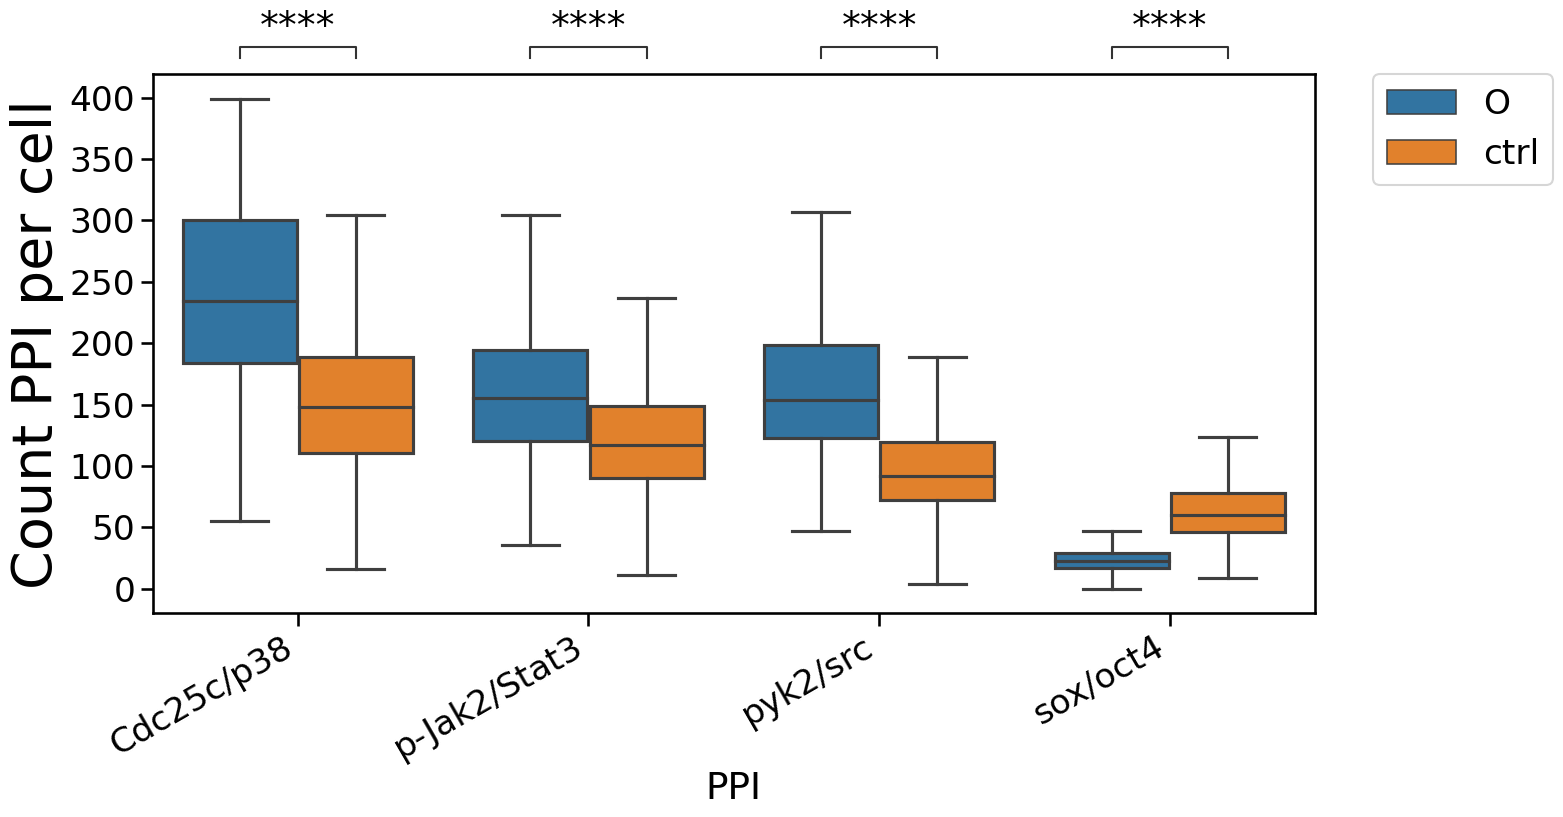

In [11]:
# Boxplot per cell
plotting = {
    "data": df_all[~df_all.PPI.isin(['b-catenin/e-cadherin'])],
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

df_all['Condition'] = df_all['Condition'].apply(lambda x: {'ctrl': 'Control', 'O': 'Treated'}.get(x, x))
df_all['Condition'].unique()

plot(plotting)

In [12]:
df_all

,Condition,FOV,Id,PPI,Count_cell,Count_nuclei,Count_cyto
0,Treated,FW1,38,Cdc25c/p38,180.0,0,180.0
1,Treated,FW1,39,Cdc25c/p38,180.0,62,118.0
3,Treated,FW1,41,Cdc25c/p38,146.0,37,109.0
4,Treated,FW1,42,Cdc25c/p38,362.0,170,192.0
5,Treated,FW1,43,Cdc25c/p38,308.0,76,232.0
...,...,...,...,...,...,...,...
6720,Control,FW1,878,sox/oct4,94.0,32,62.0
6721,Control,FW1,881,sox/oct4,60.0,40,20.0
6722,Control,FW1,883,sox/oct4,35.0,16,19.0
6723,Control,FW1,885,sox/oct4,45.0,26,19.0


In [13]:
df_all[~df_all.PPI.isin(['b-catenin/e-cadherin'])].groupby(['Condition', 'PPI'])['Count_cell'].describe().to_clipboard()

# Ki67 quantification

In [14]:
from statannotations.Annotator import Annotator
import seaborn as sns

In [15]:
# Get Co-expression data
PPI_exp_path =  data_dir / 'Navincin' / 'PPI' / 'expression'
PPI_exp_path.mkdir(parents=True, exist_ok=True)

df_Ki67 = pd.read_csv(PPI_exp_path / 'Ki67.csv', index_col=0)
df_Ki67['Ki67 Nuclei ratio'] = df_Ki67['Ki67 Area'].div(df_Ki67['Nuclei Area'])
df_Ki67['Condition'] = df_Ki67['Condition'].apply(lambda x: {'ctrl': 'Control', 'O': 'Treated'}.get(x, x))

In [16]:
df_Ki67

,Nuclei,Nuclei Area,Ki67 Area,Nuclei_Cell,Condition,Ki67 Nuclei ratio
0,23,2904.0,400.0,41.0,Treated,0.137741
1,33,4817.0,234.0,47.0,Treated,0.048578
2,41,4449.0,683.0,43.0,Treated,0.153518
3,42,4949.0,38.0,39.0,Treated,0.007678
4,43,4663.0,670.0,51.0,Treated,0.143684
...,...,...,...,...,...,...
756,868,4685.0,615.0,878.0,Control,0.131270
757,869,4195.0,311.0,885.0,Control,0.074136
758,870,3282.0,338.0,886.0,Control,0.102986
759,871,4192.0,610.0,883.0,Control,0.145515


In [17]:
# Boxplot per cell
plotting = {
    "data": df_Ki67,
    "x": "Condition",
    "y": "Ki67 Nuclei ratio",
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Treated vs. Control: Mann-Whitney-Wilcoxon test two-sided, P_val:3.406e-03 U_stat=2.062e+05


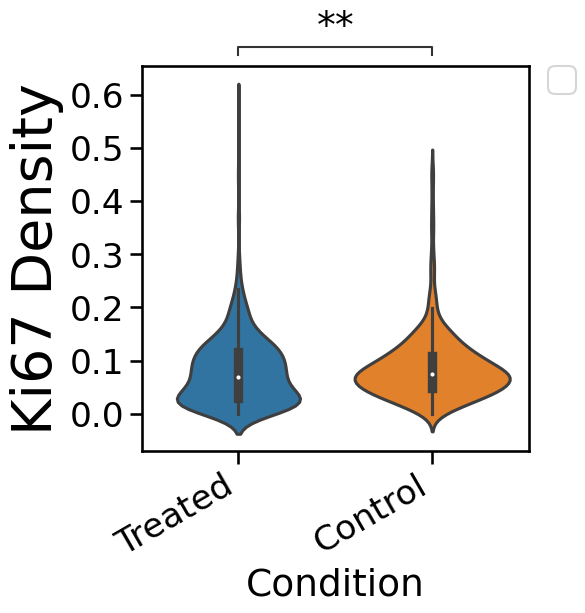

In [21]:
pairs = [('Control', 'Treated')]

with sns.plotting_context('talk', font_scale=1.5):
    fig, ax = plt.subplots(figsize=(5,5))
    ax = sns.violinplot(**plotting, showfliers=False, ax=ax)
    # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
    result = annot.apply_test().annotate()
    ax.set_ylabel('Ki67 Density', fontsize=40)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [20]:
df_Ki67.groupby('Condition')["Ki67 Nuclei ratio"].describe().to_clipboard()

# Intensity

In [17]:
from statannotations.Annotator import Annotator
import seaborn as sns

In [18]:
# Get Co-expression data
PPI_exp_path =  data_dir / 'Navincin' / 'PPI' / 'expression'

df_Ki67 = pd.read_csv(PPI_exp_path / 'Ki67_intensity.csv', index_col=0)
df_Ki67['Condition'] = df_Ki67['Condition'].apply(lambda x: {'ctrl': 'Control', 'O': 'Treated'}.get(x, x))

In [19]:
df_Ki67

,Cell,Area,Ki67,Condition
2,38,24617.0,3.527968,Treated
3,39,22241.0,2.100400,Treated
4,40,34437.0,4.631995,Treated
5,41,11747.0,4.922789,Treated
6,42,47756.0,1.849673,Treated
...,...,...,...,...
754,878,18216.0,3.912989,Control
756,881,24188.0,1.322143,Control
757,883,12183.0,4.613396,Control
758,885,14823.0,3.556567,Control


In [20]:
# Boxplot per cell
plotting = {
    "data": df_Ki67,
    "x": "Condition",
    "y": "Ki67",
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


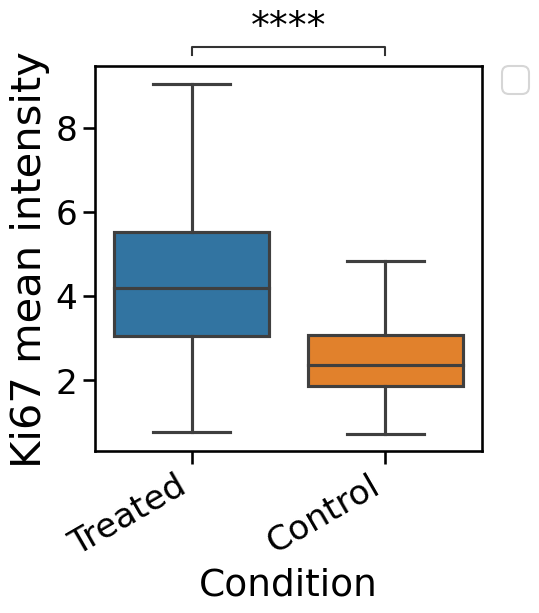

In [21]:
pairs = [('Control', 'Treated')]

with sns.plotting_context('talk', font_scale=1.5):
    fig, ax = plt.subplots(figsize=(5,5))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
    # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
    result = annot.apply_test().annotate()
    ax.set_ylabel('Ki67 mean intensity', fontsize=30)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Intensity

In [5]:
from statannotations.Annotator import Annotator
import seaborn as sns

In [6]:
# Get Co-expression data
PPI_exp_path =  data_dir / 'Navincin' / 'PPI' / 'expression'

df_Ki67 = pd.read_csv(PPI_exp_path / 'bcatenin_intensity.csv', index_col=0)
df_Ki67['Condition'] = df_Ki67['Condition'].apply(lambda x: {'ctrl': 'Control', 'O': 'Treated'}.get(x, x))

In [12]:
df_Ki67.groupby(['Condition'])['b-catenin/e-cadherin'].describe().to_clipboard()

In [25]:
# Boxplot per cell
plotting = {
    "data": df_Ki67,
    "x": "Condition",
    "y": "b-catenin/e-cadherin",
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Treated vs. Control: Mann-Whitney-Wilcoxon test two-sided, P_val:4.318e-12 U_stat=1.738e+05


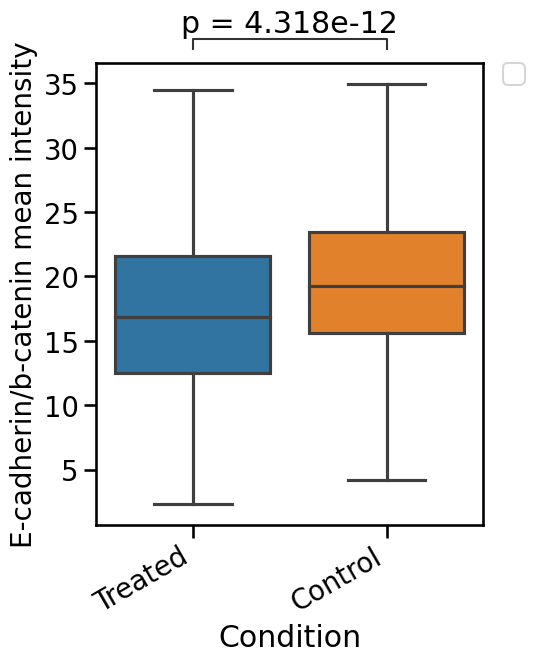

In [27]:
pairs = [('Control', 'Treated')]

with sns.plotting_context('talk', font_scale=1.2):
    fig, ax = plt.subplots(figsize=(5,6))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
    # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='full', loc='outside', show_test_name=False)
    result = annot.apply_test().annotate()
    ax.set_ylabel('E-cadherin/b-catenin mean intensity', fontsize=20)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)